<a href="https://colab.research.google.com/github/Joe-brands/g02-sms-spam/blob/master/Deep_Learning_SMS_Spam_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'		   kaggle		       shootings.csv
 household_power_consumption.zip  'my kaggle screenshot.jpg'   spam.csv


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud

In [31]:
df = pd.read_csv('/content/gdrive/My Drive/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [32]:
# make a copy of the dataset
data = df.copy() 
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#rename the label and text columns
data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

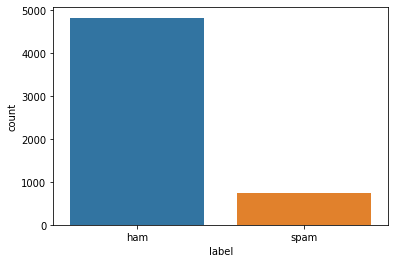

In [34]:
sns.countplot(data['label'])
plt.show()

*From the result of the plot above we see that the training dataset is imbalanced. This is good to note when doing extensive feature engineering.*

We will convert the label to numeric form. This is essential before model training, as deep learning models need data in numeric form

In [35]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

Now messages that are ham have a value of 0 in the label column, while spam messages have a 1.
We also can make a word cloud of common words used in spam or ham SMS. This can give us an idea of what kind of words are dominant in each class.
To make a word cloud, we first separate the classes into two pandas data frames as shown below:

In [36]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

In [37]:
# add a simple word cloud function as shown below
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

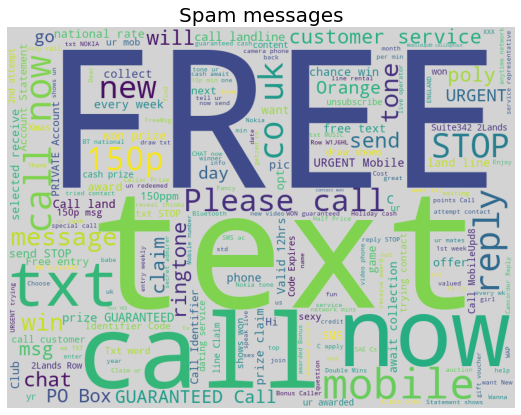

In [38]:
# word cloud for spam SMS
show_wordcloud(data_spam, "Spam messages")

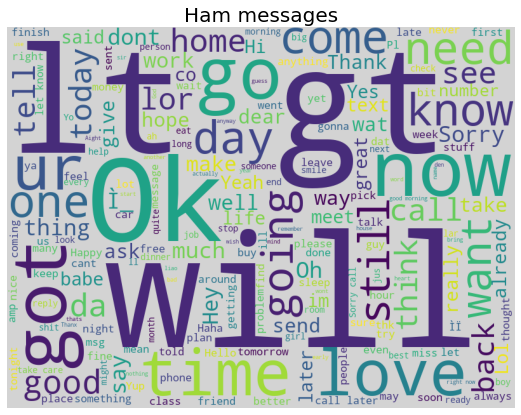

In [39]:
# word cloud for ham SMS
show_wordcloud(data_ham, "Ham messages")

**Preparing the dataset for training**

In [40]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [41]:
#split the dataset
X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [43]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[6, 35, 16, 20], [109, 168, 6, 17, 4, 1897, 7, 34, 71, 2, 261, 120, 419, 14, 877, 62]]


Deep learning models expect your input data to come in the same shape. Because were working with text data, some texts will be longer than others. This means that we need to pad each text so that they all have the same length as seen below:

In [44]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[   6   35   16 ...    0    0    0]
 [  71    2  261 ...   14  877   62]
 [   4  878  293 ...    2 1190  879]
 ...
 [1624   29 2507 ...  241   29 2508]
 [ 797 2371 1236 ...    0    0    0]
 [   8  151   20 ...    8  297  173]]


**Building your deep learning model**

Now that our text data is in numeric form, we can now feed it into a model and start training. In the next section, we’re going to create a simple Keras model to train on the encoded text data.

In [45]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 24)             183744    
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               96500     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [46]:
# We can call the fit method to start training as shown below:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
131/131 [==============================] - 1s 9ms/step - loss: 0.1836 - accuracy: 0.9270 - val_loss: 0.1031 - val_accuracy: 0.9792
Epoch 2/50
131/131 [==============================] - 1s 7ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.1180 - val_accuracy: 0.9785
Epoch 3/50
131/131 [==============================] - 1s 7ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.1751 - val_accuracy: 0.9770
Epoch 4/50
131/131 [==============================] - 1s 7ms/step - loss: 1.1745e-04 - accuracy: 1.0000 - val_loss: 0.2611 - val_accuracy: 0.9821
Epoch 5/50
131/131 [==============================] - 1s 6ms/step - loss: 3.4930e-07 - accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.9813
Epoch 6/50
131/131 [==============================] - 1s 7ms/step - loss: 8.4953e-09 - accuracy: 1.0000 - val_loss: 0.3434 - val_accuracy: 0.9813
Epoch 7/50
131/131 [==============================] - 1s 7ms/step - loss: 3.6563e-09 - accuracy: 1.0000 - val_loss: 0.3722 - val_accurac

In [47]:
# we can also calculate and display more metrics as you will see below.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [48]:
preds = (model.predict(padded_test) > 0.5).astype("int32")
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1202
           1       0.96      0.88      0.92       191

    accuracy                           0.98      1393
   macro avg       0.97      0.94      0.95      1393
weighted avg       0.98      0.98      0.98      1393

Accuracy : 0.9791816223977028


0.9791816223977028

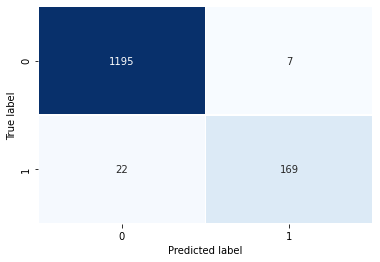

In [49]:
plot_confusion_matrix(y_test, preds)

In [50]:
model.save("spam_model")

INFO:tensorflow:Assets written to: spam_model/assets


In [51]:
#To save the tokenizer
with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

**Making predictions**

In [54]:
#from token import *
s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [56]:
sms = ["Happy Sunday.How are you doing today? "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

0


The sample sms text above was classified as ham hence the value 0. I also tried another sample sms text and it was classified as spam which is 1. The model works just fine.

In this notebook, I've  tried to build an SMS spam detection model with Deep Learning. 
We may need to build a web/mobile application which can be built in Python using the Flask framework. Then we will work with the Twilio SMS API so that we’ll be able to classify SMS messages sent to a particular phone number registered to a Twilio account.

So lets look at the direction we want to take on this project.